In [ ]:
# Team RaySimon F3 Innovate Frost Risk Forecasting Challenge Notebook
# Simon Yan (simonryan@ucsb.edu)
# Raymond Yan (rey5066@psu.edu)

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import brier_score_loss, roc_auc_score, precision_recall_curve, auc
from sklearn.calibration import calibration_curve
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [5]:
df = pd.read_csv("cimis-hourly-data-multiple-stations/cimis_all_stations.csv")

In [6]:
# station elevations
# map to each row in dataset

station_ids = [105, 124, 125, 131, 146, 15, 182, 194, 195, 2, 205, 206, 39, 47, 7, 70, 71, 80]
elevations = [191, 183, 500, 265, 410, 193, 300, 165, 935, 285, 730, 150, 337, 45, 185, 33, 35, 339]

elev_df = pd.DataFrame({
    "Stn Id": station_ids,
    "Elevation_ft": elevations
})

df["Stn Id"] = df["Stn Id"].astype(int)
elev_df["Stn Id"] = elev_df["Stn Id"].astype(int)
df = df.merge(elev_df, on="Stn Id", how="left")

In [7]:
# cyclic encoding for date and time
# so that december to january is not like 12 back down to 1
df["Hour (PST)"] = df["Hour (PST)"].astype(str).str.zfill(4)

# turn 24:00 into 00:00 for datetype format
mask_2400 = df["Hour (PST)"] == "2400"
df.loc[mask_2400, "Hour (PST)"] = "0000"

df["Date"] = pd.to_datetime(df["Date"])

# 00:00 should represent beginning of next day (10-24 24:00 = 10-25 00:00)
df.loc[mask_2400, "Date"] += pd.Timedelta(days=1)

df["datetime"] = pd.to_datetime(
    df["Date"].dt.strftime("%Y-%m-%d") + " " +
    df["Hour (PST)"].str[:2] + ":" + df["Hour (PST)"].str[2:]
)

# set datetime index
df = df.set_index("datetime")

# cyclic encoding variables
hour = df.index.hour
month = df.index.month


df["hour_sin"] = np.sin(2 * np.pi * hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * hour / 24)

df["month_sin"] = np.sin(2 * np.pi * month / 12)
df["month_cos"] = np.cos(2 * np.pi * month / 12)

In [8]:
# drop in temperature in past 3, 6, 12, and 24 hours
df["temp_drop_3h"] = df["Air Temp (C)"].diff(3)
df["temp_drop_6h"] = df["Air Temp (C)"].diff(6)
df["temp_drop_12h"] = df["Air Temp (C)"].diff(12)
df["temp_drop_24h"] = df["Air Temp (C)"].diff(24)

# dew point depression - how far air is from being saturated, air can’t absorb anymore moisture, will become condensation/frost
df["dewpoint_dep"] = df["Air Temp (C)"] - df["Dew Point (C)"]

# vapor pressure deficit - how dry air is, lower = more vapor and frost risk
df["svp"] = 0.61078 * 10 ** ((7.5 * df["Air Temp (C)"]) / (237.3 + df["Air Temp (C)"]))
df["avp"] = 0.61078 * 10 ** ((7.5 * df["Dew Point (C)"]) / (237.3 + df["Dew Point (C)"]))
df["vpd"] = df["svp"] - df["avp"]
df.drop(columns=["svp", "avp"], inplace=True)

# soil temperature - air temp > soil temp by a lot = bigger frost risk
df["air_soil_temp_diff"] = df["Air Temp (C)"] - df["Soil Temp (C)"]

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:21:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:22:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:23:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


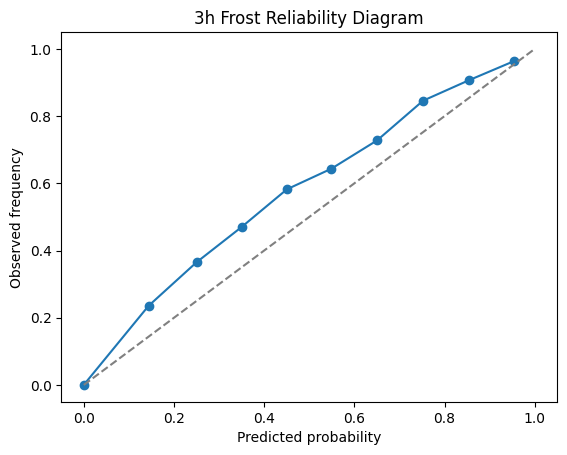

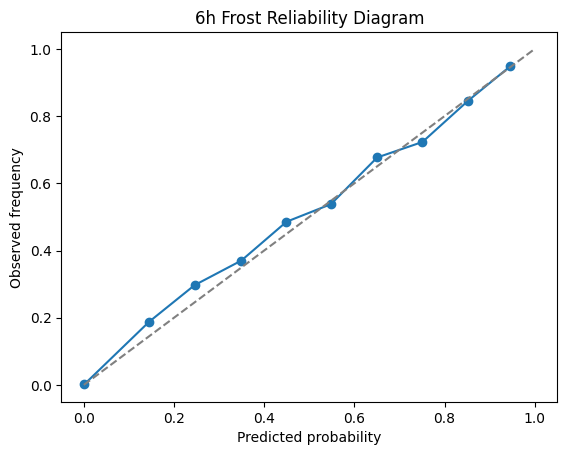

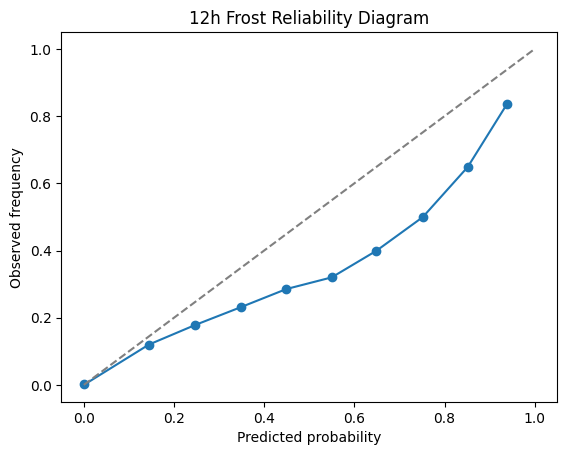

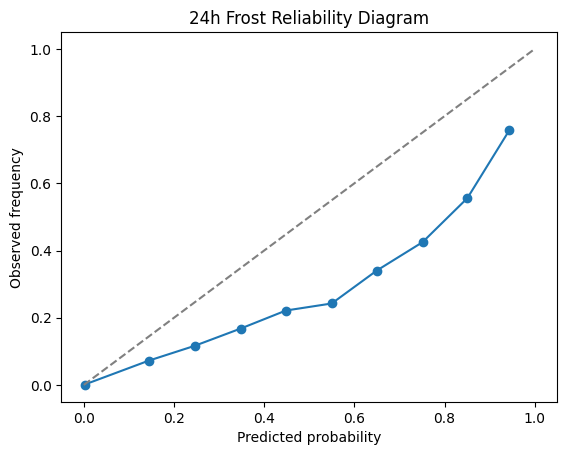

  Horizon  Brier Score   ROC-AUC    PR-AUC       ECE
0      3h     0.003585  0.997513  0.867440  0.001782
1      6h     0.004728  0.994769  0.775625  0.001059
2     12h     0.007266  0.990368  0.606882  0.004192
3     24h     0.008928  0.987563  0.537952  0.008475


In [9]:
# if frost actually occurred based on temperature
df["frost"] = (df["Air Temp (C)"] <= 0).astype(int)
df["frost_3h"]  = df["frost"].shift(-3)
df["frost_6h"]  = df["frost"].shift(-6)
df["frost_12h"] = df["frost"].shift(-12)
df["frost_24h"]  = df["frost"].shift(-24)

# remove rows with nan (some early rows where no prev 3-24 hrs data)
df.dropna(inplace=True)

# features to train model on
features = [
    "Air Temp (C)", "Dew Point (C)", "Soil Temp (C)", "Rel Hum (%)",
    "Wind Speed (m/s)", "Sol Rad (W/sq.m)", 
    "dewpoint_dep", "vpd", "air_soil_temp_diff",
    "temp_drop_3h", "temp_drop_6h", "temp_drop_12h", "temp_drop_24h",
    "hour_sin", "hour_cos", "month_sin", "month_cos", "Elevation_ft"
]

train_size = int(len(df) * 0.8)
x_train = df[features].iloc[:train_size]
x_test  = df[features].iloc[train_size:]

y_train_dict = {h: df[f"frost_{h}"].iloc[:train_size] for h in ["3h","6h","12h","24h"]}
y_test_dict  = {h: df[f"frost_{h}"].iloc[train_size:] for h in ["3h","6h","12h","24h"]}

params = {
    "3h":  {
        "n_estimators": 500,
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "min_child_weight": 3,
        "gamma": 0,
        "scale_pos_weight": 1,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    },
    "6h":  {
        "n_estimators": 500,
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "min_child_weight": 4,
        "gamma": 0.05,
        "scale_pos_weight": 2,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    },
    "12h": {
        "n_estimators": 600,
        "max_depth": 6,
        "learning_rate": 0.03,
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "min_child_weight": 4,
        "gamma": 0.05,
        "scale_pos_weight": 5,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    },
    "24h": {
        "n_estimators": 700,
        "max_depth": 6,
        "learning_rate": 0.03,
        "subsample": 0.6,
        "colsample_bytree": 0.7,
        "min_child_weight": 5,
        "gamma": 0.1,
        "scale_pos_weight": 10,
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }
}

# xgboost model for 3hr, 6hr, 12hr and 24hr frost predictions
models = {}
for h in ["3h","6h","12h","24h"]:
    model = xgb.XGBClassifier(**params[h])
    model.fit(x_train, y_train_dict[h])
    models[h] = model

# model evaluation
results = []

for h in ["3h","6h","12h","24h"]:
    model = models[h]
    y_test = y_test_dict[h]
    prob = model.predict_proba(x_test)[:,1]

    # Brier Score
    brier = brier_score_loss(y_test, prob)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, prob)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)

    # ECE
    prob_true, prob_pred = calibration_curve(y_test, prob, n_bins=10)
    ece = np.sum(np.abs(prob_pred - prob_true) * np.histogram(prob, bins=10)[0]/len(prob))

    results.append({
        "Horizon": h,
        "Brier Score": brier,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "ECE": ece
    })

    # Reliability Diagram
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"{h} Frost Reliability Diagram")
    plt.show()

# Display results
results_df = pd.DataFrame(results)
print(results_df)


In [100]:
# EXTERNAL DATA
# open meteo public API for historial ERA5 data

# open-metro client with caching and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
om_client = openmeteo_requests.Client(session=retry_session)

# coordinates of the 18 weather stations
coordinates = [
    {"lat": 36.634028, "lon": -120.38181, "name": "Westlands"},
    {"lat": 36.890056, "lon": -120.731410, "name": "Panoche"},
    {"lat": 35.205583, "lon": -118.778410, "name": "Arvin-Edison"},
    {"lat": 38.649964, "lon": -121.218870, "name": "Fair Oaks"},
    {"lat": 35.505833, "lon": -119.691140, "name": "Belridge"},
    {"lat": 36.157972, "lon": -119.851430, "name": "Stratford"},
    {"lat": 35.8330, "lon": -119.255960, "name": "Delano"},
    {"lat": 37.727194, "lon": -120.850860, "name": "Oakdale"},
    {"lat": 38.887603, "lon": -121.102910, "name": "Auburn"},
    {"lat": 36.336222, "lon": -120.112910, "name": "FivePoints"},
    {"lat": 36.175833, "lon": -120.360270, "name": "Coalinga"},
    {"lat": 37.545869, "lon": -120.754530, "name": "Denair II"},
    {"lat": 36.597444, "lon": -119.504040, "name": "Parlier"},
    {"lat": 37.928258, "lon": -121.6599, "name": "Brentwood"},
    {"lat": 36.851222, "lon": -120.590920, "name": "FirebaughTelles"},
    {"lat": 37.834822, "lon": -121.223190, "name": "Manteca"},
    {"lat": 37.645222, "lon": -121.187760, "name": "Modesto"},
    {"lat": 36.820833, "lon": -119.742310, "name": "Fresno State"},
]

# variables to fetch
daily_vars = [
    "daylight_duration",
    "sunshine_duration", 
    "shortwave_radiation_sum", 
    "temperature_2m_mean", 
    "temperature_2m_max", 
    "temperature_2m_min", 
    "et0_fao_evapotranspiration", 
    "precipitation_sum"
]
hourly_vars = [
    "soil_moisture_0_to_7cm",
    "apparent_temperature",
    "rain",
    "pressure_msl",
    "weather_code",
    "cloud_cover",
    "cloud_cover_low",
]

url = "https://archive-api.open-meteo.com/v1/archive"

# loop through weather stations
for coord in coordinates:
    
    all_hourly = []
    all_daily = []

    params = {
        "latitude": coord["lat"],
        "longitude": coord["lon"],
        "start_date": "2010-09-28",
        "end_date": "2025-09-28",
        "daily": daily_vars,
        "hourly": hourly_vars,
        "timezone": "America/Los_Angeles",
    }
    
    # fetch data
    responses = om_client.weather_api(url, params=params)
    response = responses[0]  # single location

    # hourly data
    hourly = response.Hourly()
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            periods=len(hourly.Variables(0).ValuesAsNumpy()),
            freq=pd.Timedelta(seconds=hourly.Interval())
        ),
        "location": coord["name"]
    }
    for i, var in enumerate(hourly_vars):
        hourly_data[var] = hourly.Variables(i).ValuesAsNumpy()
    all_hourly.append(pd.DataFrame(hourly_data))

    hourly_df = pd.concat(all_hourly, ignore_index=True)
    
    # daily data
    daily = response.Daily()

    daily_dates = pd.date_range(
        start="2010-09-28",
        end="2025-09-28",
        freq="D"
    )
    
    n_days = len(daily_dates)
    
    daily_data = {
        "date": daily_dates,
        "location": coord["name"]
    }
    
    # daily data should be mapped in all 24 hourly rows
    for i, var in enumerate(daily_vars):
        vals = daily.Variables(i).ValuesAsNumpy()
    
        if isinstance(vals, (int, float)):
            vals = np.repeat(vals, n_days)
    
        if len(vals) < n_days:
            padded = np.full(n_days, np.nan)
            padded[:len(vals)] = vals
            vals = padded
    
        if len(vals) > n_days:
            vals = vals[:n_days]
    
        daily_data[var] = vals
    
    daily_df = pd.DataFrame(daily_data)

    # turn date into datetime format
    hourly_df['date'] = pd.to_datetime(hourly_df['date'], errors='coerce')
    hourly_df['datetime'] = hourly_df['date'].dt.tz_convert(None)
    
    hourly_df['date'] = hourly_df['datetime'].dt.date

    # merge daily + hourly data
    hourly_df['merge'] = hourly_df['date'].astype(str)
    daily_df['merge'] = daily_df['date'].astype(str)
    
    merged_df = hourly_df.merge(
        daily_df.drop(columns=['date']),   # remove daily's date to avoid clash
        on=['location', 'merge'],
        how='left'
    )

    merged_df = merged_df.drop(columns=['date'])

    # save CSVs
    filename = f"{coord['name']}_hourly_daily.csv"
    merged_df.to_csv(filename, index=False)
    print(f"Saved merged CSV for {coord['name']} as {filename}")

OpenMeteoRequestsError: failed to request 'https://archive-api.open-meteo.com/v1/archive': {'reason': 'Daily API request limit exceeded. Please try again tomorrow.', 'error': True}

In [10]:
# combine external data with given dataset

stations = [
    "Westlands",
    "Panoche",
    "Arvin-Edison",
    "Fair Oaks",
    "Belridge",
    "Stratford",
    "Delano",
    "Oakdale",
    "Auburn",
    "FivePoints",
    "Coalinga",
    "Denair II",
    "Parlier",
    "Brentwood",
    "FirebaughTelles",
    "Manteca",
    "Modesto",
    "Fresno State",
]

all_station_csv = []

for station in stations:
    file_name = f"{station}_hourly_daily.csv"
    
    # read csv
    station_csv = pd.read_csv(file_name)

    # convert to datetime and remove timezone
    station_csv['datetime'] = pd.to_datetime(station_csv['datetime'], errors='coerce')
    
    # rename column to Stn Name
    station_csv.rename(columns={'location': 'Stn Name'}, inplace=True)
    
    # fix spelling (Firebaugh/Telles can't be file name)
    if station == "FirebaughTelles":
        station_csv['Stn Name'] = station_csv['Stn Name'].str.replace(
            "FirebaughTelles", "Firebaugh/Telles"
        )
    
    # drop merge helper column
    if 'merge' in station_csv.columns:
        station_csv = station_csv.drop(columns=['merge'])

    cols_front = ['datetime', 'Stn Name']
    other_cols = [c for c in station_csv.columns if c not in cols_front]
    station_csv = station_csv[cols_front + other_cols]
    
    all_station_csv.append(station_csv)

# combine all 18 station data
all_station = pd.concat(all_station_csv, ignore_index=True)

print("Combined all stations")

Combined all stations


In [11]:
# merge with given dataset

external_df = df.merge(
    all_station,
    on=['datetime', 'Stn Name'],
    how='left'
)

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:51:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:54:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:57:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:01:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


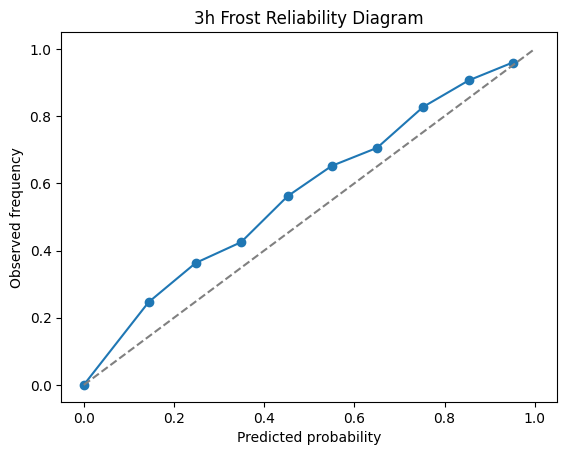

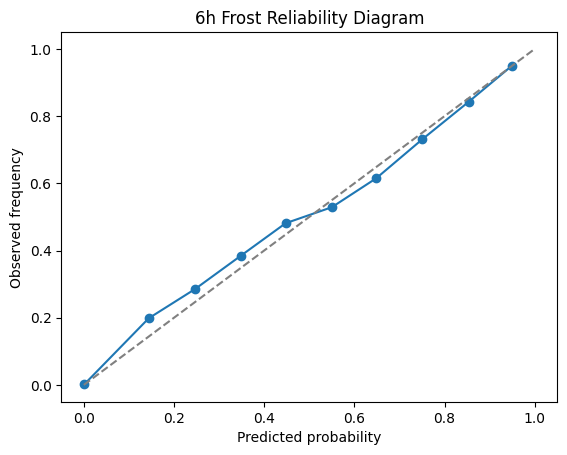

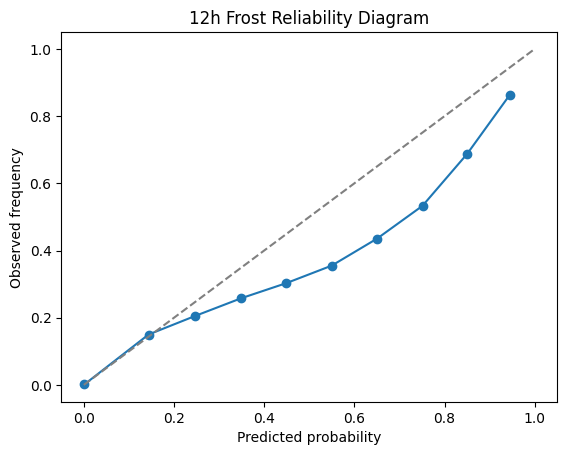

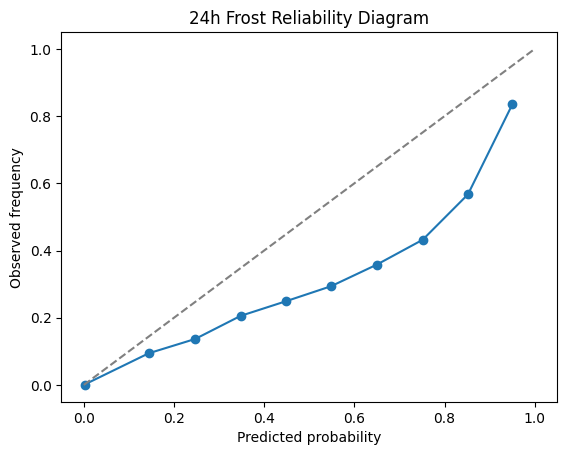

  Horizon  Brier Score   ROC-AUC    PR-AUC       ECE  Temp MAE  Temp RMSE
0      3h     0.003472  0.997882  0.873682  0.001584  1.033198   1.388590
1      6h     0.004623  0.995800  0.788443  0.001140  1.436951   1.875648
2     12h     0.006756  0.991543  0.631130  0.002949  1.628273   2.138542
3     24h     0.007314  0.991261  0.649790  0.005716  1.740438   2.316805


In [23]:
# train external dataset

external_df["frost"] = (external_df["Air Temp (C)"] <= 0).astype(int)
external_df["frost_3h"]  = external_df["frost"].shift(-3)
external_df["frost_6h"]  = external_df["frost"].shift(-6)
external_df["frost_12h"] = external_df["frost"].shift(-12)
external_df["frost_24h"] = external_df["frost"].shift(-24)

# temperature labels for regression
external_df["temp_3h"]  = external_df["Air Temp (C)"].shift(-3)
external_df["temp_6h"]  = external_df["Air Temp (C)"].shift(-6)
external_df["temp_12h"] = external_df["Air Temp (C)"].shift(-12)
external_df["temp_24h"] = external_df["Air Temp (C)"].shift(-24)

external_df.dropna(inplace=True)

features = [
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "temp_drop_3h", "temp_drop_6h", "temp_drop_12h", "temp_drop_24h",
    "Air Temp (C)", "Dew Point (C)", "Rel Hum (%)", "Soil Temp (C)", "Wind Speed (m/s)",
    "dewpoint_dep", "vpd", "air_soil_temp_diff",
    "soil_moisture_0_to_7cm", "apparent_temperature", "rain", "pressure_msl",
    "weather_code", "cloud_cover", "cloud_cover_low",
    "daylight_duration", "sunshine_duration", "shortwave_radiation_sum",
    "temperature_2m_mean", "temperature_2m_max", "temperature_2m_min",
    "et0_fao_evapotranspiration", "precipitation_sum",
    "Elevation_ft"
]

# 80/20 split
train_size = int(len(external_df) * 0.8)
x_train = external_df[features].iloc[:train_size]
x_test  = external_df[features].iloc[train_size:]

y_train_frost = {h: external_df[f"frost_{h}"].iloc[:train_size] for h in ["3h","6h","12h","24h"]}
y_test_frost  = {h: external_df[f"frost_{h}"].iloc[train_size:] for h in ["3h","6h","12h","24h"]}

y_train_temp = {h: external_df[f"temp_{h}"].iloc[:train_size] for h in ["3h","6h","12h","24h"]}
y_test_temp  = {h: external_df[f"temp_{h}"].iloc[train_size:] for h in ["3h","6h","12h","24h"]}

models_clf = {}
models_reg = {}

for h in ["3h","6h","12h","24h"]:
    # classifier
    clf = xgb.XGBClassifier(**params[h])
    clf.fit(x_train, y_train_frost[h])
    models_clf[h] = clf

    # regressor
    reg = xgb.XGBRegressor(
        n_estimators=params[h]["n_estimators"],
        max_depth=params[h]["max_depth"],
        learning_rate=params[h]["learning_rate"],
        subsample=params[h]["subsample"],
        colsample_bytree=params[h]["colsample_bytree"],
        random_state=42
    )
    reg.fit(x_train, y_train_temp[h])
    models_reg[h] = reg

results = []
for h in ["3h","6h","12h","24h"]:
    # frost probability
    clf = models_clf[h]
    y_test = y_test_frost[h]
    prob = clf.predict_proba(x_test)[:,1]

    # metrics
    brier = brier_score_loss(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    prob_true, prob_pred = calibration_curve(y_test, prob, n_bins=10)
    ece = np.sum(np.abs(prob_pred - prob_true) * np.histogram(prob, bins=10)[0]/len(prob))

    # predicted temperature
    reg = models_reg[h]
    y_pred_temp = reg.predict(x_test)
    temp_mae = np.mean(np.abs(y_test_temp[h] - y_pred_temp))
    temp_rmse = np.sqrt(np.mean((y_test_temp[h] - y_pred_temp)**2))

    results.append({
        "Horizon": h,
        "Brier Score": brier,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "ECE": ece,
        "Temp MAE": temp_mae,
        "Temp RMSE": temp_rmse
    })

    # reliability diagram
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"{h} Frost Reliability Diagram")
    plt.show()

results_df = pd.DataFrame(results)
print(results_df)

In [24]:
import random

def forecast(models_clf, models_reg, external_df, features):
    # randomly pick a row
    idx = random.choice(external_df.index.tolist())
    
    # keep only the numeric features used for the model
    x = external_df.loc[idx:idx, features]
    
    print(f"{external_df.loc[idx, 'Stn Name']} at {external_df.loc[idx, 'datetime']}\n")

    for h in ["3h","6h","12h","24h"]:
        # frost probability
        prob = models_clf[h].predict_proba(x)[:,1][0]
        
        # temperature prediction
        predicted_temp = models_reg[h].predict(x)[0]

        print(
            f"There is a {prob*100:.1f}% chance of frost in the next {h}, "
            f"predicted temperature: {predicted_temp:.2f} °C"
        )

    print("\n")

In [29]:
for _ in range(20):
    forecast(models_clf, models_reg, external_df, features)

Panoche at 2021-03-24 12:00:00

There is a 0.0% chance of frost in the next 3h, predicted temperature: 21.19 °C
There is a 0.0% chance of frost in the next 6h, predicted temperature: 19.24 °C
There is a 0.0% chance of frost in the next 12h, predicted temperature: 9.36 °C
There is a 0.0% chance of frost in the next 24h, predicted temperature: 18.74 °C


Oakdale at 2025-05-18 10:00:00

There is a 0.0% chance of frost in the next 3h, predicted temperature: 23.69 °C
There is a 0.0% chance of frost in the next 6h, predicted temperature: 26.00 °C
There is a 0.0% chance of frost in the next 12h, predicted temperature: 16.14 °C
There is a 0.0% chance of frost in the next 24h, predicted temperature: 20.50 °C


Panoche at 2021-05-21 17:00:00

There is a 0.0% chance of frost in the next 3h, predicted temperature: 16.43 °C
There is a 0.0% chance of frost in the next 6h, predicted temperature: 11.62 °C
There is a 0.0% chance of frost in the next 12h, predicted temperature: 8.88 °C
There is a 0.0% c

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:11:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:15:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:23:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


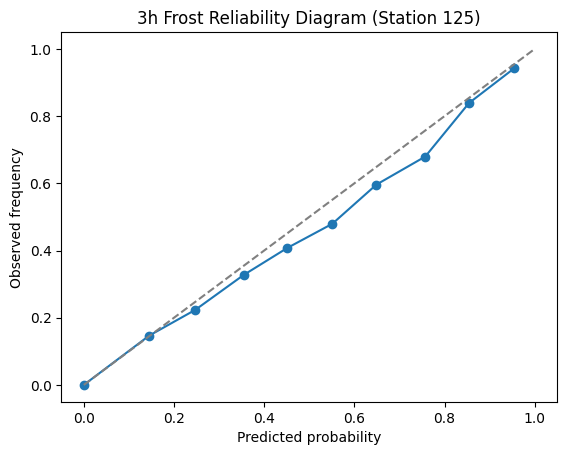

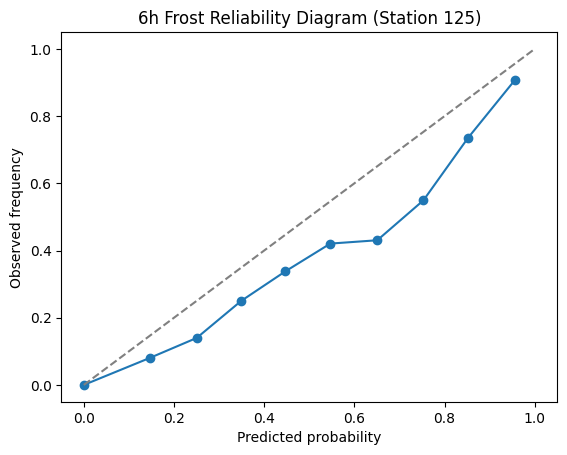

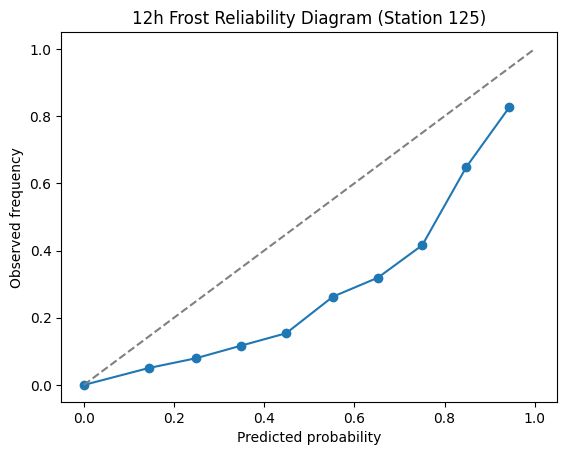

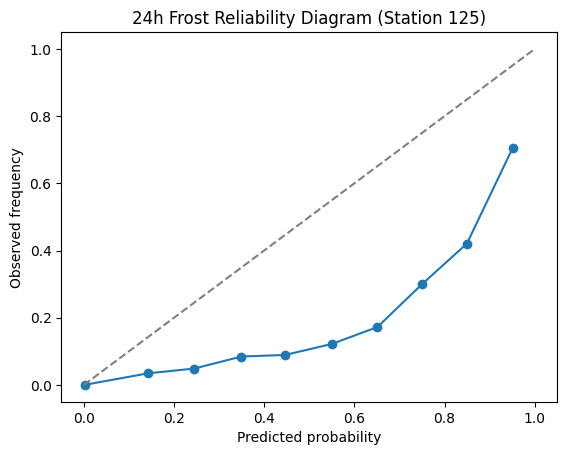

  Horizon  Brier Score   ROC-AUC    PR-AUC       ECE  Temp MAE  Temp RMSE
0      3h     0.002254  0.998569  0.842734  0.000326  1.332824   1.776757
1      6h     0.002983  0.997714  0.775673  0.002021  1.743392   2.281794
2     12h     0.004613  0.996020  0.662762  0.006009  1.974026   2.553272
3     24h     0.006896  0.993872  0.609978  0.010604  1.908776   2.581722


In [30]:
# LEAVE ONE STATION OUT (LOSO)

# pick a random station to leave out
station_id = random.choice(station_ids)

train_df = external_df[external_df["Stn Id"] != station_id].copy()
test_df  = external_df[external_df["Stn Id"] == station_id].copy()

x_train = train_df[features]
x_test  = test_df[features]

# frost labels
y_train_frost = {h: train_df[f"frost_{h}"] for h in ["3h","6h","12h","24h"]}
y_test_frost  = {h: test_df[f"frost_{h}"]  for h in ["3h","6h","12h","24h"]}

# temperature labels
y_train_temp = {h: train_df[f"temp_{h}"] for h in ["3h","6h","12h","24h"]}
y_test_temp  = {h: test_df[f"temp_{h}"]  for h in ["3h","6h","12h","24h"]}

models_clf = {}
models_reg = {}
predictions_prob = {}
predictions_temp = {}

for h in ["3h","6h","12h","24h"]:
    # classifier
    clf = xgb.XGBClassifier(**params[h])
    clf.fit(x_train, y_train_frost[h])
    models_clf[h] = clf
    predictions_prob[h] = clf.predict_proba(x_test)[:,1]

    # regressor
    reg = xgb.XGBRegressor(
        n_estimators=params[h]["n_estimators"],
        max_depth=params[h]["max_depth"],
        learning_rate=params[h]["learning_rate"],
        subsample=params[h]["subsample"],
        colsample_bytree=params[h]["colsample_bytree"],
        random_state=42
    )
    reg.fit(x_train, y_train_temp[h])
    models_reg[h] = reg
    predictions_temp[h] = reg.predict(x_test)

# Evaluate
results = []

for h in ["3h","6h","12h","24h"]:
    # frost metrics
    y_test = y_test_frost[h]
    prob = predictions_prob[h]

    brier = brier_score_loss(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    prob_true, prob_pred = calibration_curve(y_test, prob, n_bins=10)
    ece = np.sum(np.abs(prob_pred - prob_true) * np.histogram(prob, bins=10)[0]/len(prob))

    # temperature metrics
    y_test_t = y_test_temp[h]
    y_pred_t = predictions_temp[h]
    temp_mae = np.mean(np.abs(y_test_t - y_pred_t))
    temp_rmse = np.sqrt(np.mean((y_test_t - y_pred_t)**2))

    results.append({
        "Horizon": h,
        "Brier Score": brier,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "ECE": ece,
        "Temp MAE": temp_mae,
        "Temp RMSE": temp_rmse
    })

    # reliability diagram
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"{h} Frost Reliability Diagram (Station {station_id})")
    plt.show()

results_df = pd.DataFrame(results)
print(results_df)